In [1]:
import os

import torch
import torch.utils.data as torch_data

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from fastmri.utils import load_torch_model, fastMRIData, compare_imgs
from fastmri.model import UnetGenerator

In [2]:
def load_generators(prefix, values):
    generators = dict()
    for v in values:
        generator_path = os.path.join(PATH_TO_RESULTS, prefix + v, 'G_best.pth')
        generator_state = torch.load(generator_path)

        generator = UnetGenerator()
        generator.load_state_dict(generator_state)

        generators[v] = generator

    return generators

In [3]:
acceleration = 4

PATH_TO_RESULTS = f'results/x{acceleration}'
PARAM_PREFIX = 'l1_lambda_'

PATH_TO_SOURCE_VAL = 'data/ax_t2_single_source_val'
PATH_TO_SAMPLED_VAL = f'data/ax_t2_single_sampled_x{acceleration}_val'

device = torch.device('cpu')

In [4]:
results = [f for f in os.listdir(PATH_TO_RESULTS) if f.startswith(PARAM_PREFIX)]
values = sorted([v.replace(PARAM_PREFIX, '') for v in results], key=lambda x: int(x))

generators = load_generators(PARAM_PREFIX, values)

In [5]:
fmri_val = fastMRIData(PATH_TO_SOURCE_VAL, PATH_TO_SAMPLED_VAL)
fmri_val.images = fmri_val.images[:1000]
data_loader = torch_data.DataLoader(fmri_val, batch_size=10, num_workers=4)

item: 603


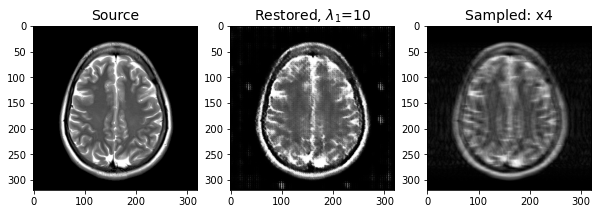

Source & Sampled:
	MAE	PSNR	SSIM
score	0.061	19.792	0.597

Source & Restored:
	MAE	PSNR	SSIM
score	0.046	20.716	0.745



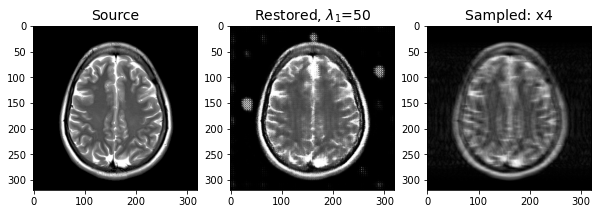

Source & Sampled:
	MAE	PSNR	SSIM
score	0.061	19.792	0.597

Source & Restored:
	MAE	PSNR	SSIM
score	0.041	20.293	0.820



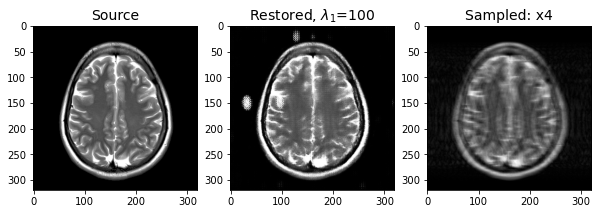

Source & Sampled:
	MAE	PSNR	SSIM
score	0.061	19.792	0.597

Source & Restored:
	MAE	PSNR	SSIM
score	0.041	20.275	0.856



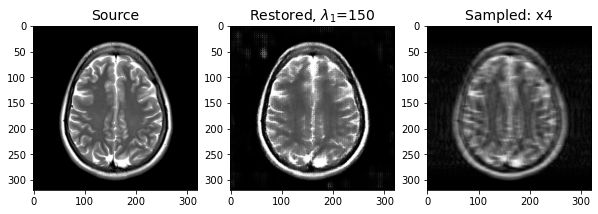

Source & Sampled:
	MAE	PSNR	SSIM
score	0.061	19.792	0.597

Source & Restored:
	MAE	PSNR	SSIM
score	0.040	21.972	0.776



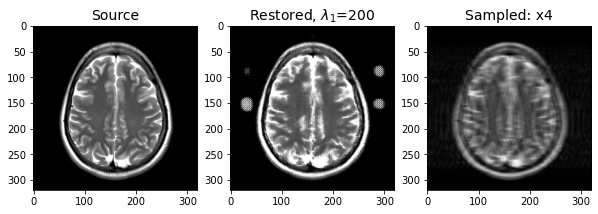

Source & Sampled:
	MAE	PSNR	SSIM
score	0.061	19.792	0.597

Source & Restored:
	MAE	PSNR	SSIM
score	0.055	17.923	0.821



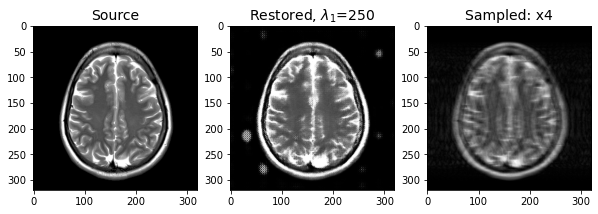

Source & Sampled:
	MAE	PSNR	SSIM
score	0.061	19.792	0.597

Source & Restored:
	MAE	PSNR	SSIM
score	0.051	18.817	0.812



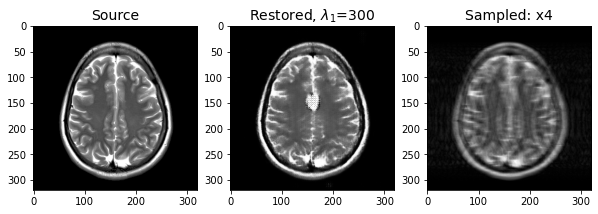

Source & Sampled:
	MAE	PSNR	SSIM
score	0.061	19.792	0.597

Source & Restored:
	MAE	PSNR	SSIM
score	0.031	23.280	0.890



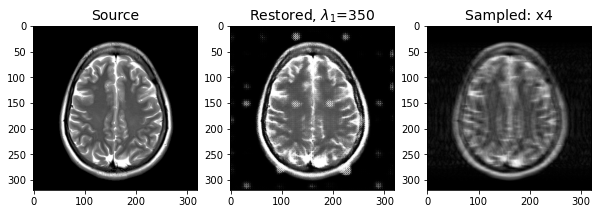

Source & Sampled:
	MAE	PSNR	SSIM
score	0.061	19.792	0.597

Source & Restored:
	MAE	PSNR	SSIM
score	0.050	18.910	0.804



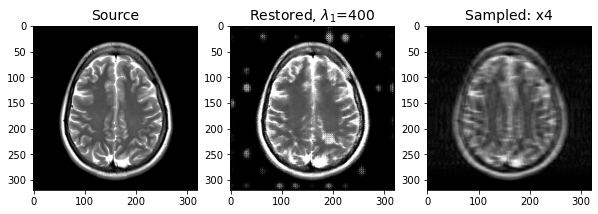

Source & Sampled:
	MAE	PSNR	SSIM
score	0.061	19.792	0.597

Source & Restored:
	MAE	PSNR	SSIM
score	0.052	18.463	0.791



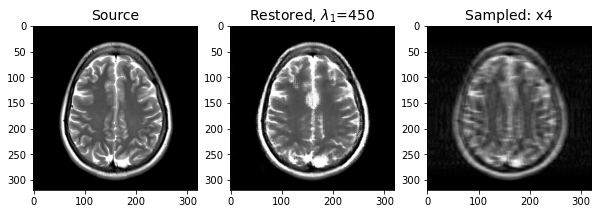

Source & Sampled:
	MAE	PSNR	SSIM
score	0.061	19.792	0.597

Source & Restored:
	MAE	PSNR	SSIM
score	0.039	21.391	0.869



In [6]:
i = np.random.randint(0, len(fmri_val))
print(f'item: {i}')

for v, G in generators.items():
    source, sampled = fmri_val.__getitem__(i)
    
    restored = G(sampled.reshape(1, 1, 320, 320)).data

    fig, axis = plt.subplots(1, 3, figsize=(10, 10))
    axis[0].imshow(source[0], cmap='gray', vmin=0, vmax=1)
    axis[0].set_title(f'Source', fontsize=14)
    axis[1].imshow(restored.squeeze(), cmap='gray', vmin=0, vmax=1)
    axis[1].set_title(fr'Restored, $\lambda_1$={v}', fontsize=14)
    axis[2].imshow(sampled[0], cmap='gray', vmin=0, vmax=1)
    axis[2].set_title(f'Sampled: x{acceleration}', fontsize=14)

    plt.show()

    print('Source & Sampled:')
    compare_imgs(source, sampled, verbose=True)
    print('\nSource & Restored:')
    compare_imgs(source, restored[0].data, verbose=True)
    print()

In [7]:
%%time

G_res = dict()

for v, G in generators.items():

    mae = []
    psnr = []
    ssim = []

    print('Value:', v)
    for sources, sampled in tqdm(data_loader):

        G.to(device)
        sampled.to(device)

        restored = G(sampled).data

        for source, restored_one in zip(sources, restored):
            res = compare_imgs(source, restored_one, verbose=False)

            mae.append(res[0])
            psnr.append(res[1])
            ssim.append(res[2])

    del G
    Gv_res = {'mae': np.mean(mae), 'psnr': np.mean(psnr), 'ssim': np.mean(ssim)}
    G_res[v] = Gv_res

G_res

Value: 10



Value: 50



Value: 100



Value: 150



Value: 200



Value: 250



Value: 300



Value: 350



Value: 400



Value: 450



CPU times: user 1h 34min 14s, sys: 7min 24s, total: 1h 41min 39s
Wall time: 25min 28s


{'10': {'mae': 0.03897572,
  'psnr': 22.080845455247825,
  'ssim': 0.844293475708487},
 '50': {'mae': 0.03311386,
  'psnr': 23.624889167794834,
  'ssim': 0.876674277016649},
 '100': {'mae': 0.031051945,
  'psnr': 24.23551998472522,
  'ssim': 0.8914827202068757},
 '150': {'mae': 0.03299242,
  'psnr': 23.720113964856676,
  'ssim': 0.8761756598363343},
 '200': {'mae': 0.03432695,
  'psnr': 23.375861199774697,
  'ssim': 0.8800800781436082},
 '250': {'mae': 0.03022053,
  'psnr': 24.46126701458571,
  'ssim': 0.8967249915705056},
 '300': {'mae': 0.032680023,
  'psnr': 23.71951196841321,
  'ssim': 0.8814661361622307},
 '350': {'mae': 0.030140975,
  'psnr': 24.616733081730136,
  'ssim': 0.8987311931330717},
 '400': {'mae': 0.029768525,
  'psnr': 24.708658279523117,
  'ssim': 0.899088718769631},
 '450': {'mae': 0.031442806,
  'psnr': 24.10915575715805,
  'ssim': 0.8895811953721775}}

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


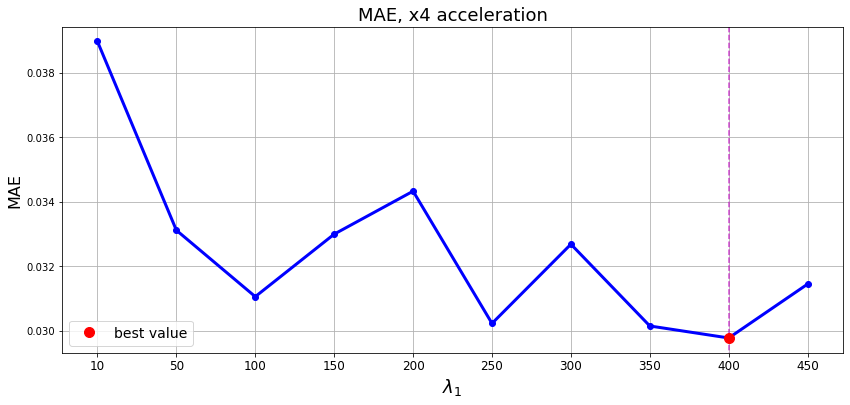

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


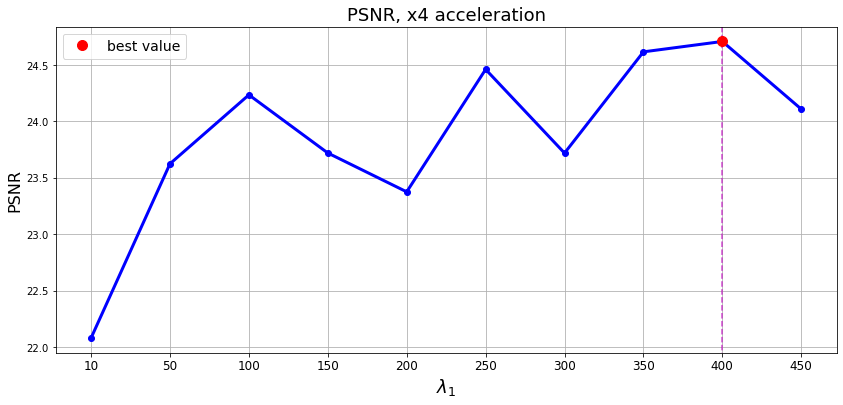

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


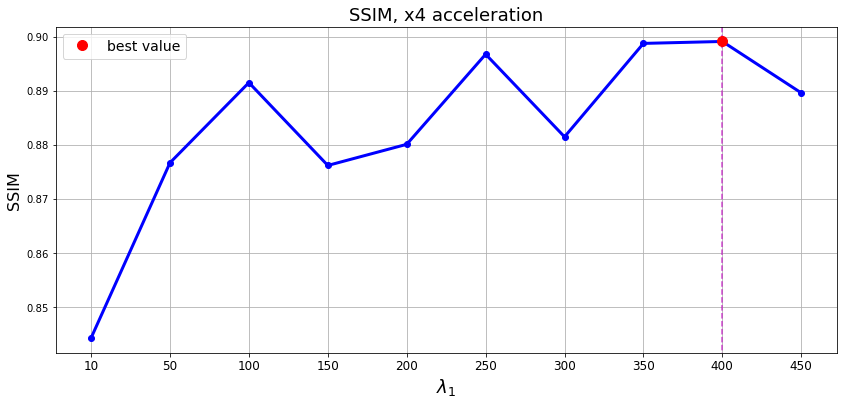

In [8]:
metric_names = ['mae', 'psnr', 'ssim']

mae = [v['mae'] for v in G_res.values()]
psnr = [v['psnr'] for v in G_res.values()]
ssim = [v['ssim'] for v in G_res.values()]

metrics = [mae, psnr, ssim]

for metric, name in zip(metrics, metric_names):

    plt.figure(figsize=(14, 6))

    plt.plot(metric, '-ob', linewidth=3)
    
    if name == 'mae':
        i_best = np.argmin(metric)
    else:
        i_best = np.argmax(metric)
        
    axis = plt.axis()
    
    plt.plot([i_best, i_best], [0, 100], 'm--', alpha=0.7)
    plt.plot(i_best, metric[i_best], 'ro', markersize=10, label='best value')
    
    
    plt.xlim(axis[:2])
    plt.ylim(axis[2:])
    plt.grid()
    plt.xticks(range(len(values)), values, fontsize=12)
    plt.xlabel(f'$\lambda_1$', fontsize=18)
    plt.ylabel(name.upper(), fontsize=16)
    plt.title(f'{name.upper()}, x{acceleration} acceleration', fontsize=18)
    plt.legend(loc='best', fontsize=14)

    plt.savefig(f'{name}_x{acceleration}.eps', format='eps')
    plt.show()